In [16]:
import numpy as np
import pandas as pd

def randomize_tracktemp(df_random,
                        fluctuation_std=0.3,
                        min_temp_clip=30,
                        max_temp_clip=45,
                        cooling_after_lap=None,
                        cooling_bias=-0.05):
    """
    Randomly generate realistic TrackTemp values for 78 laps.

    Parameters:
    - df_random: DataFrame containing at least 'LapNumber' and 'TrackTemp'.
    - fluctuation_std: Standard deviation of lap-to-lap temperature change (°C).
    - min_temp_clip: Minimum allowed TrackTemp (°C).
    - max_temp_clip: Maximum allowed TrackTemp (°C).
    - cooling_after_lap: If set, apply slight cooling drift after this lap.
    - cooling_bias: Mean shift for lap-to-lap fluctuation after cooling lap (°C).

    Returns:
    - tracktemp_randomized_df: DataFrame with LapNumber and randomized TrackTemp.
    """

    randomized_tracktemps = []

    # Step 1: Pick Lap 1
    lap1_data = df_random[df_random['LapNumber'] == 1]['TrackTemp']
    lap1_temp = lap1_data.sample(n=1, random_state=np.random.randint(10000)).values[0]
    randomized_tracktemps.append(lap1_temp)

    # Step 2: Generate laps 2–78
    for lap in range(2, 79):
        prev_temp = randomized_tracktemps[-1]

        if cooling_after_lap is not None and lap > cooling_after_lap:
            fluctuation = np.random.normal(loc=cooling_bias, scale=fluctuation_std)
        else:
            fluctuation = np.random.normal(loc=0, scale=fluctuation_std)

        new_temp = prev_temp + fluctuation
        new_temp = np.clip(new_temp, min_temp_clip, max_temp_clip)

        randomized_tracktemps.append(new_temp)

    # Assemble final DataFrame
    tracktemp_randomized_df = pd.DataFrame({
        'LapNumber': np.arange(1, 79),
        'TrackTemp': randomized_tracktemps
    })

    return tracktemp_randomized_df

def generate_weight_per_lap(car_type='V10'):
    """
    Generate a dataframe of Weight per LapNumber for a given car type.

    Args:
    - car_type: String, either 'V6' or 'V10'

    Returns:
    - weight_df: DataFrame with columns ['LapNumber', 'Weight']
    """

    # Define base weights for each car type
    base_weights = {
        'V6': 798,   # Base weight for V6 hybrid car (without fuel)
        'V10': 783   # Base weight for V10 hybrid car (without fuel)
    }

    # Normalize car_type input
    car_type = car_type.upper()

    # Validate input
    if car_type not in base_weights:
        raise ValueError("car_type must be 'V6' or 'V10'")

    base_weight = base_weights[car_type]

    # Constants
    laps_total = 78
    fuel_start_min = 100
    fuel_start_max = 110
    fuel_end_min = 1
    fuel_end_max = 2

    # Generate randomized fuel values
    initial_fuel = np.random.uniform(fuel_start_min, fuel_start_max)
    final_fuel = np.random.uniform(fuel_end_min, fuel_end_max)
    burn_per_lap = (initial_fuel - final_fuel) / (laps_total - 1)

    # Generate weight per lap
    weights = []
    for lap in range(1, laps_total + 1):
        current_fuel = initial_fuel - (lap - 1) * burn_per_lap
        current_weight = base_weight + current_fuel
        weights.append((lap, current_weight))

    # Return DataFrame
    weight_df = pd.DataFrame(weights, columns=['LapNumber', 'Weight'])
    return weight_df

def generate_trackstatus_per_lap():
    """
    Generate a DataFrame with randomized TrackStatus per LapNumber for 78 laps.

    Returns:
    - trackstatus_df: DataFrame with columns ['LapNumber', 'TrackStatus']
    """

    # Constants
    laps_total = 78
    trackstatus_choices = [0, 1, 2, 3]  # 0: AC, 1: YF, 2: VSC, 3: SC
    probabilities = [0.8957, 0.0762, 0.0064, 0.0217]  # From your EDA

    # Randomly choose one status per lap
    trackstatus_list = np.random.choice(trackstatus_choices, size=laps_total, p=probabilities)

    # Create dataframe
    trackstatus_df = pd.DataFrame({
        'LapNumber': np.arange(1, laps_total + 1),
        'TrackStatus': trackstatus_list
    })

    return trackstatus_df

import pandas as pd
import numpy as np

def generate_throttle_rpm_per_lap(df_random, car_type='V10', transition_throttle=60):
    """
    Generate a dataframe with randomized Throttle and calculated RPM per lap
    for either V6 or V10 engine type.

    Args:
    - df_random: Input DataFrame with 'LapNumber' and 'Throttle' columns
    - car_type: 'V6' or 'V10'
    - transition_throttle: Throttle % at which model switches between quadratic and linear

    Returns:
    - result_df: DataFrame with ['LapNumber', 'Throttle', 'RPM']
    """

    # Normalize input
    car_type = car_type.upper()

    # Constants
    laps_total = 78

    # Coefficients from piecewise regression model
    # For Throttle ≤ transition_throttle (Quadratic)
    quad_intercept = 3497.86
    quad_coef1 = 219.56
    quad_coef2 = -2.03

    # For Throttle > transition_throttle (Linear)
    lin_intercept = 7224.98
    lin_coef = -72.24

    lap_results = []

    for lap in range(1, laps_total + 1):
        lap_data = df_random[df_random['LapNumber'] == lap]

        if lap_data.empty:
            continue

        sampled_throttle = lap_data['Throttle'].sample(n=1).values[0]

        # Predict RPM based on throttle
        if sampled_throttle <= transition_throttle:
            rpm = (quad_intercept
                   + quad_coef1 * sampled_throttle
                   + quad_coef2 * sampled_throttle**2)
        else:
            rpm = lin_intercept + lin_coef * sampled_throttle

        # Scale only if V10
        if car_type == 'V10':
            rpm *= (20000 / 15000)  # Scale up by 1.333...

        lap_results.append((lap, sampled_throttle, rpm))

    result_df = pd.DataFrame(lap_results, columns=['LapNumber', 'Throttle', 'RPM'])

    return result_df


def generate_full_lap_data(laps, df_random, car_type):
    """
    Generates a full dataset per lap by combining fixed variables (laps) with
    randomized TrackTemp, Weight, TrackStatus, Throttle, and RPM.

    Args:
    - laps: DataFrame containing fixed variables and 'LapNumber'.
    - df_random: DataFrame containing random pool for throttle (must have 'LapNumber' and 'Throttle').

    Returns:
    - final_df: DataFrame with all fixed and random variables combined, LapNumber dropped.
    """

    # 1. Generate random variables
    tracktemp_df = randomize_tracktemp(df_random)
    weight_df = generate_weight_per_lap(car_type)
    trackstatus_df = generate_trackstatus_per_lap()
    throttle_rpm_df = generate_throttle_rpm_per_lap(df_random,car_type)

    # 2. Merge everything on 'LapNumber'
    merged_df = laps.merge(tracktemp_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(weight_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(trackstatus_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(throttle_rpm_df, on='LapNumber', how='left')

    # 3. Drop LapNumber
    merged_df = merged_df.drop(columns=['LapNumber'])

    return merged_df

In [2]:
import pandas as pd
import numpy as np
df_source = pd.read_csv('regression_mc_sim.csv')

In [ ]:
df_source[df_source['LapNumber']==23]

In [3]:
def create_fixed_variables():
    laps = pd.DataFrame({'LapNumber': range(1, 79)})

    # ---- Step 2: Aggregate fixed variables from source ----
    agg_fixed = df_source.groupby('LapNumber').agg({
        'Throttle': 'mean',
        'Brake': 'mean',
        'DRS': 'mean'
    }).reset_index()

    # Round Throttle, Brake, DRS to integers
    agg_fixed['Brake'] = agg_fixed['Brake'].round().astype(int)
    agg_fixed['DRS'] = agg_fixed['DRS'].round().astype(int)

    # Merge into the lap DataFrame
    laps = laps.merge(agg_fixed, on='LapNumber', how='left')

    # ---- Step 3: Pit Duration ----
    # Average of nonzero pit_durations
    avg_pit_duration = df_source[df_source['PitDuration'] > 0]['PitDuration'].mean()

    # Assign pit_duration
    laps['PitDuration'] = 0.0
    laps.loc[laps['LapNumber'] == 32, 'PitDuration'] = avg_pit_duration

    # ---- Step 4: Compound ----
    laps['Compound'] = np.where(laps['LapNumber'] <= 31, 5, 6)

    # ---- Step 5: Tyre Life ----
    laps['TyreLife'] = np.where(
        laps['LapNumber'] <= 31,
        laps['LapNumber'],                   # Laps 1–31
        laps['LapNumber'] - 31                # Restart count from 1 after pit stop
    )
    #laps.to_csv('MC_Fixed_data.csv', index=False)
    return laps

In [4]:
laps = create_fixed_variables()
#laps = pd.read_csv('MC_Fixed_data.csv')
laps

,LapNumber,Throttle,Brake,DRS,PitDuration,Compound,TyreLife
0,1,40.101048,112,0,0.0,5,1
1,2,41.665370,102,5,0.0,5,2
2,3,41.956385,98,7,0.0,5,3
3,4,42.088928,97,7,0.0,5,4
4,5,42.470642,98,5,0.0,5,5
...,...,...,...,...,...,...,...
73,74,45.910959,91,4,0.0,6,43
74,75,44.908604,91,4,0.0,6,44
75,76,42.370703,104,3,0.0,6,45
76,77,36.147459,128,3,0.0,6,46


In [5]:
df_source

,LapNumber,TrackTemp,RPM,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
0,1.0,33.75,9531.494048,46.101190,99,0,91.614,0,6.0,20.0,1,1,840.921071,0.0
1,2.0,33.90,9394.374251,47.080838,93,16,80.619,1,1.0,6.0,0,1,839.546466,0.0
2,3.0,33.90,9429.505952,48.086310,89,24,79.812,1,1.0,7.0,0,0,838.171860,0.0
3,4.0,33.90,9437.838906,47.723404,85,22,79.562,1,1.0,8.0,0,0,836.797254,0.0
4,5.0,33.60,9427.572727,46.830303,92,19,79.400,1,1.0,9.0,0,0,835.422649,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8290,72.0,40.50,9382.875887,50.872340,90,0,80.585,0,4.0,2.0,1,0,807.392401,0.0
8291,73.0,40.80,8971.025559,43.853035,102,0,75.233,1,4.0,3.0,1,0,806.115441,0.0
8292,74.0,40.80,9461.837545,52.931408,85,0,80.473,0,4.0,4.0,1,0,804.838481,0.0
8293,75.0,40.60,9103.670175,47.568421,88,0,74.718,1,4.0,5.0,1,0,803.561522,0.0


In [6]:
df_random = df_source[['LapNumber','TrackTemp','Weight','TrackStatus','Throttle','RPM']]
df_random

,LapNumber,TrackTemp,Weight,TrackStatus,Throttle,RPM
0,1.0,33.75,840.921071,1,46.101190,9531.494048
1,2.0,33.90,839.546466,1,47.080838,9394.374251
2,3.0,33.90,838.171860,0,48.086310,9429.505952
3,4.0,33.90,836.797254,0,47.723404,9437.838906
4,5.0,33.60,835.422649,0,46.830303,9427.572727
...,...,...,...,...,...,...
8290,72.0,40.50,807.392401,0,50.872340,9382.875887
8291,73.0,40.80,806.115441,0,43.853035,8971.025559
8292,74.0,40.80,804.838481,0,52.931408,9461.837545
8293,75.0,40.60,803.561522,0,47.568421,9103.670175


In [ ]:
# Let's first explore the TrackTemp values
tracktemp_stats = df_random.groupby('LapNumber')['TrackTemp'].agg(['min', 'max', 'mean', 'std'])

# Print basic statistics
print(tracktemp_stats)

# Plot mean TrackTemp per lap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(tracktemp_stats.index, tracktemp_stats['mean'], marker='o')
plt.fill_between(tracktemp_stats.index,
                 tracktemp_stats['mean'] - tracktemp_stats['std'],
                 tracktemp_stats['mean'] + tracktemp_stats['std'],
                 alpha=0.3)
plt.xlabel('Lap Number')
plt.ylabel('Track Temperature (°C)')
plt.title('Mean Track Temperature per Lap with Variance')
plt.grid(True)
plt.show()


In [ ]:
# Call the function
tracktemp_randomized_df = randomize_tracktemp(
    df_random,
    fluctuation_std=0.3,
    min_temp_clip=30,
    max_temp_clip=45,
    cooling_after_lap=30,  # Start slight cooling after lap 30
    cooling_bias=-0.05     # Slight downward trend after lap 30
)

# View
print(tracktemp_randomized_df)

# Optional: Save
#tracktemp_randomized_df.to_csv('MC_TrackTemp_randomized.csv', index=False)


In [ ]:
# Example usage:
# For V10 Hybrid
weight_v10_df = generate_weight_per_lap()

# View
weight_v10_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your random variable df is already loaded as df_random

# Step 1: Overall Value Counts
print("Overall TrackStatus value counts:")
print(df_random['TrackStatus'].value_counts(normalize=True) * 100)  # % distribution

# Step 2: Per Lap - % of green track (TrackStatus=1)
green_track_per_lap = df_random.groupby('LapNumber')['TrackStatus'].apply(lambda x: (x == 1).mean() * 100)

# Step 3: Plot % of green track per lap
plt.figure(figsize=(10,6))
plt.plot(green_track_per_lap.index, green_track_per_lap.values, marker='o')
plt.xlabel('Lap Number')
plt.ylabel('% Green Track (TrackStatus=1)')
plt.title('Percentage of Green Track Per Lap')
plt.ylim(0, 105)
plt.grid(True)
plt.show()

# Step 4 (Optional): Identify laps where green track % drops
laps_with_incidents = green_track_per_lap[green_track_per_lap < 90]
print("\nLaps with significant non-green track activity:")
print(laps_with_incidents)


In [ ]:
# Generate TrackStatus list
trackstatus_list = generate_trackstatus_per_lap()

# View first few
trackstatus_list  # Example output: [0, 0, 1, 0, 0, 0, 0, 3, 0, 0]


In [ ]:
# Example usage:

# Suppose your df_random is already loaded
throttle_rpm_df = generate_throttle_rpm_per_lap(df_random)

# View
throttle_rpm_df


In [ ]:
laps

In [ ]:
laps.drop('Throttle', axis=1, inplace=True)

In [ ]:
laps

In [20]:
# Assuming you have:
# - laps dataframe with fixed variables
# - df_random dataframe with throttle pool

final_lap_data = generate_full_lap_data(laps.copy(), df_random, car_type='v10')

# View
final_lap_data.columns


Index(['Throttle_x', 'Brake', 'DRS', 'PitDuration', 'Compound', 'TyreLife',
       'TrackTemp', 'Weight', 'TrackStatus', 'Throttle_y', 'RPM'],
      dtype='object')

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def train_random_forest(df):
    """
    Train a simple Random Forest Regressor on the given dataframe without hyperparameter tuning.

    Args:
    - df: Input DataFrame

    Returns:
    - model: Trained Random Forest model
    - metrics: Dictionary with MSE, MAE, R²
    """

    # ---- Step 1: Define features and target ----
    X = df.drop(['LapNumber','LapTime', 'FreshTyre', 'IsPersonalBest'], axis=1)
    y = df["LapTime"]

    # ---- Step 2: Train/test split ----
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # ---- Step 3: Train Random Forest Regressor ----
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # ---- Step 4: Predict and evaluate ----
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Random Forest Regression Results:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    return model, metrics, X

In [11]:
# Suppose df is your final MC simulation dataframe
df_regression = pd.read_csv('regression_final.csv')
best_model, metrics, X = train_random_forest(df_regression)

# Access best_model.predict() later to predict new lap times!


Random Forest Regression Results:
Mean Squared Error (MSE): 10.36
Mean Absolute Error (MAE): 1.26
R² Score: 0.9119


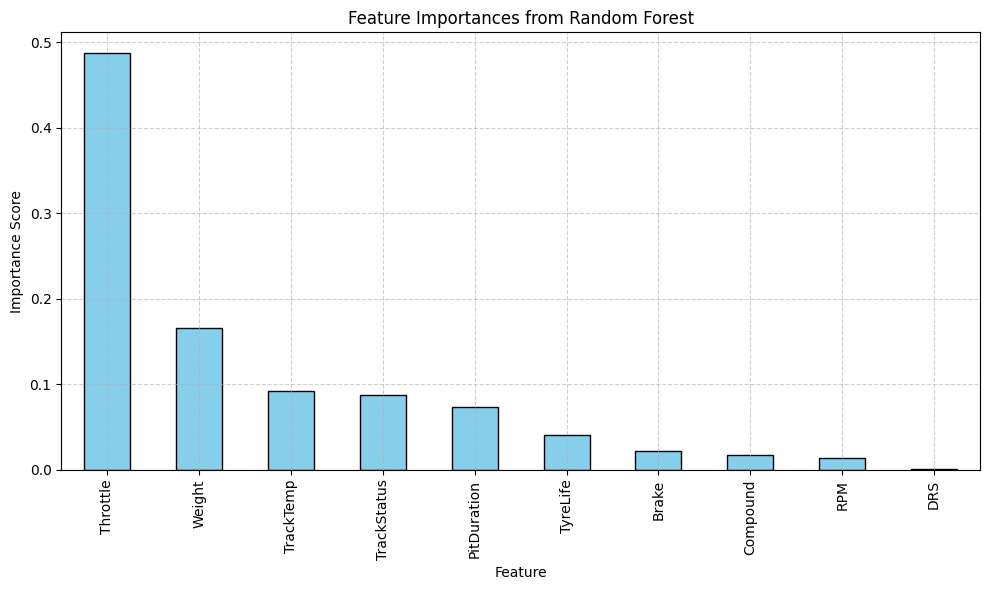

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have:
# - model: your trained RandomForestRegressor
# - X: the training feature matrix (or use df.drop([...], axis=1) again)

# Step 1: Extract importances and pair with column names
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)

# Step 2: Sort by importance (descending)
feature_importances = feature_importances.sort_values(ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
def monte_carlo_simulation(model, laps, df_random, car_type, n_simulations=5000):
    """
    Run Monte Carlo simulations to predict race times and output a DataFrame.

    Args:
    - model: Trained Random Forest model
    - laps: DataFrame with fixed variables (must include 'LapNumber')
    - df_random: DataFrame with random pool for throttle and tracktemp generation
    - n_simulations: Number of Monte Carlo simulations to run (default=5000)

    Returns:
    - race_times_df: DataFrame with columns ['SimulationNumber', 'RaceTime']
    """

    simulation_numbers = []
    race_times = []

    for sim in range(1, n_simulations + 1):
        # Step 1: Generate a new randomized lap dataset
        sim_df = generate_full_lap_data(laps.copy(), df_random, car_type)

        correct_feature_order = [
        'TrackTemp', 'RPM', 'Throttle', 'Brake', 'DRS',
        'Compound', 'TyreLife', 'TrackStatus', 'Weight', 'PitDuration'
        ]
        sim_df = sim_df[correct_feature_order]
        # Step 2: Predict lap times
        lap_times = model.predict(sim_df)

        # Step 3: Sum up all 78 lap times to get total race time
        total_race_time = np.sum(lap_times)

        # Step 4: Store the simulation number and race time
        simulation_numbers.append(sim)
        race_times.append(total_race_time)

    # Create DataFrame
    race_times_df = pd.DataFrame({
        'SimulationNumber': simulation_numbers,
        'RaceTime': race_times
    })

    return race_times_df

In [18]:
# Example usage:

# Run the simulation
race_times_df_v10 = monte_carlo_simulation(best_model, laps, df_random, n_simulations=5000, car_type='v10')
race_times_df_v6 = monte_carlo_simulation(best_model, laps, df_random, n_simulations=5000, car_type='v6')
# View



KeyError: "['Throttle'] not in index"

In [ ]:
race_times_df_v10

In [ ]:
race_times_df_v6

In [ ]:
race_times_df_v6.to_csv('race_times_v6.csv')
race_times_df_v10.to_csv('race_times_v10.csv')

# MC Sim 2

In [ ]:
import pandas as pd
df = pd.read_csv('regression_final.csv')

In [ ]:
df

In [ ]:
df.columns

In [ ]:
from scipy.stats import ttest_ind

def simulate_weight_threshold_effect(model, laps, df_random, car_type='V10', n_samples=5000, weight_threshold=700):
    """
    Monte Carlo test of threshold effect in race time based on weight.

    Args:
    - model: trained RandomForestRegressor
    - laps: fixed data (78 laps)
    - df_random: raw data with throttle, temp, etc.
    - car_type: 'V6' or 'V10'
    - n_samples: number of simulations
    - weight_threshold: kg value to test threshold hypothesis

    Returns:
    - sim_df: full DataFrame of all lap predictions with weight labels
    """
    sim_results = []

    for _ in range(n_samples):
        # Generate randomized lap input using your notebook's functions
        sim_df = generate_full_lap_data(laps.copy(), df_random, car_type=car_type)

        # Extract average weight per lap
        avg_weight = sim_df['Weight'].mean()

        # Drop irrelevant columns and match order
        #sim_df = sim_df.drop(columns=['FreshTyre', 'IsPersonalBest'])
        #correct_columns = ['TrackTemp', 'RPM', 'Throttle', 'Brake', 'DRS',
        #                   'Compound', 'TyreLife', 'TrackStatus', 'Weight', 'PitDuration']
        #sim_df = sim_df[correct_columns]

        correct_feature_order = [
        'TrackTemp', 'RPM', 'Throttle', 'Brake', 'DRS',
        'Compound', 'TyreLife', 'TrackStatus', 'Weight', 'PitDuration'
        ]
        sim_df = sim_df[correct_feature_order]

        # Predict lap times and total race time
        total_time = model.predict(sim_df).sum()

        sim_results.append({
            'RaceTime': total_time,
            'AvgWeight': avg_weight,
            'WeightGroup': 'Low' if avg_weight < weight_threshold else 'High'
        })

    sim_df = pd.DataFrame(sim_results)

    # Perform one-tailed t-test (H₁: Low weight yields faster race times)
    t_stat, p_value = ttest_ind(sim_df[sim_df['WeightGroup'] == 'Low']['RaceTime'],
                                sim_df[sim_df['WeightGroup'] == 'High']['RaceTime'],
                                alternative='less')

    print(f"\n--- Threshold Test at {weight_threshold}kg ---")
    print(f"Low Group Mean RaceTime:  {sim_df[sim_df['WeightGroup'] == 'Low']['RaceTime'].mean():.2f} s")
    print(f"High Group Mean RaceTime: {sim_df[sim_df['WeightGroup'] == 'High']['RaceTime'].mean():.2f} s")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.05:
        print("✅ Reject Null Hypothesis: Weight threshold affects race time.")
    else:
        print("❌ Fail to Reject Null: No significant difference found.")

    return sim_df

In [ ]:
model, _, _ = train_random_forest(df)  # your original model training

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df.Weight, df.LapTime, alpha=0.5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import Polynomial

# Load the data
df = pd.read_csv("regression_final.csv")

# Extract x and y
x = df['Weight'].values
y = df['LapTime'].values

# Fit a 2nd-degree polynomial
coeffs = np.polyfit(x, y, deg=2)  # returns [a, b, c] for ax² + bx + c
poly_func = np.poly1d(coeffs)

# Generate smooth curve
x_fit = np.linspace(x.min(), x.max(), 500)
y_fit = poly_func(x_fit)

# Plot the scatter and polynomial curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label="Actual Data", color='orange')
plt.plot(x_fit, y_fit, color='blue', linewidth=2, label="Quadratic Fit")
plt.title("Quadratic Fit: Weight vs Lap Time")
plt.xlabel("Weight (kg)")
plt.ylabel("Lap Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Show the polynomial equation
print("Fitted Polynomial (Quadratic):")
print(f"LapTime = {coeffs[0]:.5f} * Weight² + {coeffs[1]:.5f} * Weight + {coeffs[2]:.2f}")

In [ ]:
sim_df = simulate_weight_threshold_effect(model, laps, df_random, car_type='V6', weight_threshold=860)

In [ ]:
sim_df = simulate_weight_threshold_effect(model, laps, df_random, car_type='V6', weight_threshold=800)

In [ ]:
from scipy.stats import ttest_ind

def simulate_lapwise_weight_threshold_effect(model, laps, df_random, car_type='V10', n_samples=5000, weight_threshold=700):
    """
    Monte Carlo test of per-lap weight threshold effect using lap-wise comparison.

    Args:
    - model: trained regression model
    - laps: fixed lap template
    - df_random: random input source
    - car_type: 'V6' or 'V10'
    - n_samples: number of simulations
    - weight_threshold: threshold in kg for separating groups

    Returns:
    - low_weight_laps: all lap times with weight < threshold
    - high_weight_laps: all lap times with weight ≥ threshold
    """
    low_weight_laps = []
    high_weight_laps = []

    for _ in range(n_samples):
        sim_df = generate_full_lap_data(laps.copy(), df_random, car_type=car_type)

        # Ensure correct column order
        feature_cols = ['TrackTemp', 'RPM', 'Throttle', 'Brake', 'DRS',
                        'Compound', 'TyreLife', 'TrackStatus', 'Weight', 'PitDuration']
        sim_df = sim_df[feature_cols]

        # Predict lap times
        lap_times = model.predict(sim_df)

        # Append lap times to appropriate group
        for lap_time, weight in zip(lap_times, sim_df['Weight']):
            if weight < weight_threshold:
                low_weight_laps.append(lap_time)
            else:
                high_weight_laps.append(lap_time)

    # Perform one-tailed t-test
    t_stat, p_value = ttest_ind(low_weight_laps, high_weight_laps, alternative='less')

    print(f"\n--- Per-Lap Weight Threshold Test at {weight_threshold}kg ---")
    print(f"Low Weight Lap Count:  {len(low_weight_laps)}")
    print(f"High Weight Lap Count: {len(high_weight_laps)}")
    print(f"Mean Lap Time (< {weight_threshold}kg):  {np.mean(low_weight_laps):.4f} s")
    print(f"Mean Lap Time (≥ {weight_threshold}kg): {np.mean(high_weight_laps):.4f} s")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.05:
        print("✅ Reject Null Hypothesis — Lower weight leads to significantly faster laps.")
    else:
        print("❌ Fail to Reject Null — No significant lap time difference based on weight.")

    return low_weight_laps, high_weight_laps

In [ ]:
low_laps, high_laps = simulate_lapwise_weight_threshold_effect(
    model=model,
    laps=laps,
    df_random=df_random,
    car_type='V6',
    weight_threshold=800,
    n_samples=5000
)